# Final Project - Team 9 
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid
###### AAI 695-WS2 | Spring 2023


---

# CPE/EE/AAI 695-WS2  |  Final Project | Team 9
# Game Recommendations on Steam
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid

Steam is a video game digital distriburtion service and storefront where users can purchase and play games. The purpose of this project is to construct a Recommender System (RS) to predict the top-k unplayed games for a user based user history, users with similar tastes in genres, and games with similar genres to those the user likes.

We use a [dataset from Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam). The dataset consists of three CSV files. This includes a file titled ‘Games’ contains titles of games and purchasable game content, ratings, price in USD, and release dates, a ‘Users’ CSV containing information regarding the users who have reviewed the games in the ‘Games’ CSV, and a ‘Recommendations’ CSV, which offers whether a user recommends the product they reviewed. Note that personal user information is not accessible within the files.

## Set Up Environment

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095386 sha256=c55f64421ad28aa13f93f1fd9669ac9fa097484291c8d866638628ea46565f80
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
!pip install --upgrade surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install os-sys

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 75.0 MB/s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import sys
import os
import IPython
import psutil
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import GridSearchCV, PredefinedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Set the project directory correctly for colab and jupyter environments
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/AAI-695/Final-Project/' # Google Drive project directory
except ImportError:
    PROJECT_DIR = os.getcwd() # Jupyter Notebook project directory

# Set filename and path variables (used to save notebook fuctions into .py file for other notebooks to access - last step)
NOTEBOOK_NAME = "user_based_collaborative_filter"
NOTEBOOK_PATH = os.path.join(PROJECT_DIR, NOTEBOOK_NAME + '.ipynb')
FUNCTIONS_DIR = os.path.join(PROJECT_DIR, 'functions/')
DATA_DIR =      os.path.join(PROJECT_DIR, 'data/')

# Add the Functions module directory to the Python path
sys.path.append(FUNCTIONS_DIR)

Mounted at /content/drive


In [ ]:
# Import functions file (ignore pylance warning)
import utility_funcs as util
import data_preprocessing_funcs as fn

# Note: Any changes to imported function .py files requires Runtime Restart

## Load Data

In [ ]:
games = pd.read_csv("/content/drive/MyDrive/AAI-695/Data/games.csv")
recs = pd.read_csv("/content/drive/MyDrive/AAI-695/Data/recommendations.csv")
users = pd.read_csv("/content/drive/MyDrive/AAI-695/Data/users.csv")
steam_data = fn.load_data(DATA_DIR)

In [ ]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46063,758560,Versus World,2018-01-30,True,False,False,Very Positive,88,87,0.00,0.00,0.0,True
46064,886910,Bus Simulator 18 - Country Skin & Decal Pack,2018-07-05,True,False,False,Very Positive,88,118,0.00,0.00,0.0,True
46065,1477870,Elemental,2021-03-30,True,False,False,Mostly Positive,78,14,0.00,0.00,0.0,True
46066,1638430,Axial Disc 1,2021-08-15,True,False,False,Positive,95,42,0.00,0.00,0.0,True


In [ ]:
recs

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,19954,0
1,304390,4,0,2017-02-17,False,11.5,1098,1
2,1085660,2,0,2019-11-17,True,336.5,91207,2
3,703080,0,0,2022-09-23,True,27.4,93054,3
4,526870,0,0,2021-01-10,True,7.9,9106,4
...,...,...,...,...,...,...,...,...
10072265,225540,0,0,2020-10-28,True,200.1,5465564,10072265
10072266,225540,0,0,2022-07-31,True,187.0,3903623,10072266
10072267,225540,9,0,2015-12-19,True,44.7,2465684,10072267
10072268,225540,0,0,2021-10-15,True,11.9,2173819,10072268


In [ ]:
users

,user_id,products,reviews
0,5693478,156,1
1,3595958,329,3
2,1957593,176,2
3,2108293,98,2
4,2329878,144,2
...,...,...,...
5810789,2016706,3,0
5810790,2018907,0,0
5810791,2019936,0,0
5810792,2020719,0,0


*italicized text*## Preprocess Data

In [ ]:
steam_data_filt = fn.preprocess_data(steam_data, thresh=[60000, 100, 5, 1], verbose=True, plot=False)
df_games_filt, df_users_filt, df_recs_filt = fn.unpack_dict(steam_data_filt)

#####################
####  FILTERING  ####
#####################

Filter 1: Keep Reviews from Users with more than 0 hours of playtime

Games remaining (%):	 100.00%
Users remaining (%):	 99.99%
Reviews remaining (%):	 99.98%

User-Item Matrix Density (%): 0.251%

Filter 2: Keep Reviews from Users with more than 0 Games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Filter 3: Keep Reviews for Games with more than 60000 reviews

Games remaining (%):	 0.47%
Users remaining (%):	 98.66%
Reviews remaining (%):	 29.90%

User-Item Matrix Density (%): 4.3024%

Minimum number of reviews per game: 60241

Filter 4: Keep Reviews from Users with more than 100 games

Games remaining (%):	 0.47%
Users remaining (%):	 36.46%
Reviews remaining (%):	 12.53%

User-Item Matrix Density (%): 4.8247%

Minimum number of games per user: 100

Filter: Keep Reviews from Users with more than 5 Reviews

Games remaining (%):	 0.47%

In [ ]:
fn.estimate_memory_consumption(steam_data_filt, test_size=0.2, rating_metric='is_recommended', verbose=True)

###############################
####  MEMORY REQUIREMENTS  ####
###############################

Estimated Memory Consumption for Training Set (80.0%):
User-Item Matrix: (11043, 23) => 253989 total cells => 0.0002 GB
User-User Matrix: (11043, 11043) => 121947849 total cells => 0.1136 GB
Item-Item Matrix: (23, 23) => 529 total cells => 0.0000 GB


In [ ]:
print(steam_data_filt)

{'games':         app_id                         title date_release   win    mac  linux  \
8       261550  Mount & Blade II: Bannerlord   2022-10-25  True  False  False   
99      362890                    Black Mesa   2020-03-06  True  False   True   
122     582160     Assassin's Creed® Origins   2017-10-26  True  False  False   
172     755790               Ring of Elysium   2019-06-24  True  False  False   
511     552990             World of Warships   2017-11-15  True  False  False   
...        ...                           ...          ...   ...    ...    ...   
28943   700330        SCP: Secret Laboratory   2017-12-29  True  False  False   
31588   224260          No More Room in Hell   2013-10-31  True  False   True   
34307   331470            Everlasting Summer   2014-11-19  True   True   True   
38827  1832640           Mirror 2: Project X   2022-01-20  True  False  False   
42426  1625450                          Muck   2021-06-05  True   True   True   

                 

### Create Sample Test Set
For a fair comparison and evaluation of different models, it's generally a good practice for all team members to use the same training and test sets. This ensures that the performance metrics we compute for each model are comparable and not affected by differences in the data splits, and that any performance improvements can be attributed to the different algorithms, parameters, or feature engineering techniques used, rather than the random variation in the data. Moreover, using the same data splits makes it easier to combine the models in an ensemble, as we can be sure they are learning from and being evaluated on the same data.

After a thorough investigation of different splitting methods, we decide to split the data in a leave-p-out fashion, This ensures that each user is represented in both the train and test sets, which is important for evaluating the performance of our recommendation models. This approach helps the model learn from a diverse set of user-item interactions and simulates a more realistic scenario where predictions must be made for existing users with some available data. Specifically, 80% of each users' data is split into the training set, and 20% of each users' data is split into the test set.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Function to split data for a single user into train and test sets
def split_user_data(user_data, test_size=0.2):
#     print(f"Splitting data for user {user_data['user_id'].iloc[0]} with {len(user_data)} records")
    
    if len(user_data) <= 1:
        print(f"Skipping user {user_data['user_id'].iloc[0]} because there's only one record")
        return None, None
    
    train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
    return train_data, test_data

# Group data by user_id and apply the split_user_data function to each group
# Store the resulting train and test DataFrames in separate lists
train_dfs, test_dfs = zip(*df_recs_filt.groupby('user_id').apply(lambda x: split_user_data(x)).values)

# Remove None values
train_dfs = [x for x in train_dfs if x is not None]
test_dfs = [x for x in test_dfs if x is not None]

# Combine the train and test DataFrames from each user into their respective final DataFrames
train_recs = pd.concat(train_dfs).reset_index(drop=True)
test_recs = pd.concat(test_dfs).reset_index(drop=True)

In [ ]:
print(f'Number of records in the original dataset: {len(df_recs_filt)}')
print(f'Number of records in the training dataset: {len(train_recs)}')
print(f'Number of records in the testing dataset: {len(test_recs)}\n')

print(f'Number of users in the original dataset: {df_recs_filt["user_id"].nunique()}')
print(f'Number of users in the training dataset: {train_recs["user_id"].nunique()}')
print(f'Number of users in the testing dataset: {test_recs["user_id"].nunique()}\n')

print(f'Number of items in the original dataset: {df_recs_filt["app_id"].nunique()}')
print(f'Number of items in the training dataset: {train_recs["app_id"].nunique()}')
print(f'Number of items in the testing dataset: {test_recs["app_id"].nunique()}')

Number of records in the original dataset: 81640
Number of records in the training dataset: 61177
Number of records in the testing dataset: 20463

Number of users in the original dataset: 13804
Number of users in the training dataset: 13804
Number of users in the testing dataset: 13804

Number of items in the original dataset: 29
Number of items in the training dataset: 29
Number of items in the testing dataset: 28


# Cross Validation, Predictions, Model Evaluation

In [ ]:
# Defining number of folds
k = 5

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_recs[['user_id', 'app_id', 'is_recommended']], reader)

# Defining model and parameters for GridSearchCV
model = SVD

param_grid = {
    'n_factors': [5],#, 10],#, 15],
    'lr_all': [0.002],#, 0.005, 0.01, 0.015],
    'reg_all': [0.4],#, 0.6, 0.8],
    'biased': [True],#[True, False],
    'random_state': [42],
}

# Performing GridSearchCV for SVD model
gs = GridSearchCV(model, param_grid, measures=['rmse', 'mae'], cv=k, n_jobs=-1)
gs.fit(data)

print("Best parameters:", gs.best_params['rmse'])
print("Best RMSE:", gs.best_score['rmse'])
print("Best MAE:", gs.best_score['mae'])


Best parameters: {'n_factors': 5, 'lr_all': 0.002, 'reg_all': 0.4, 'biased': True, 'random_state': 42}
Best RMSE: 0.3956133232780292
Best MAE: 0.32539178282911374


In [ ]:
from surprise import accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

best_model = gs.best_estimator['rmse']
full_trainset = Dataset.load_from_df(train_recs[['user_id', 'app_id', 'is_recommended']], reader).build_full_trainset()
best_model.fit(full_trainset)

test_data = Dataset.load_from_df(test_recs[['user_id', 'app_id', 'is_recommended']], reader)
testset = test_data.construct_testset(test_data.raw_ratings)

predictions = best_model.test(testset)

y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]

# Model Eval
precision_test = precision_score(y_true, np.round(y_pred))
recall_test = recall_score(y_true, np.round(y_pred))
f1_test = f1_score(y_true, np.round(y_pred))
auc_test = roc_auc_score(y_true, y_pred)
cm_vals = confusion_matrix(y_true, np.round(y_pred))

print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 score:", f1_test)
print("Test AUC:", auc_test)
print("Test Confusion Matrix:\n", cm_vals)

Test Precision: 0.7681631846693338
Test Recall: 0.9964761660686827
Test F1 score: 0.867549853576907
Test AUC: 0.762000394843596
Test Confusion Matrix:
 [[  161  4694]
 [   55 15553]]


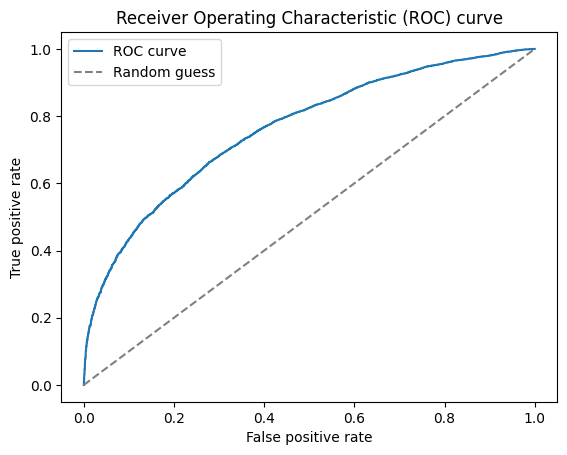

In [ ]:
from sklearn.metrics import roc_curve

# Acquiring false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plotting ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()

In [ ]:
results = pd.DataFrame(columns=['user_id', 'app_id', 'is_recommended'])
for pred in predictions:
    results = pd.concat([results, pd.DataFrame([[pred.uid, pred.iid, pred.est]], 
                                                columns=['user_id', 'app_id', 'is_recommended'])])

# Evaluation metrics
rmse, mae, fcp = accuracy.rmse(predictions), accuracy.mae(predictions), accuracy.fcp(predictions)
print("RMSE:", rmse)
print("MAE:", mae)
print("FCP:", fcp)

RMSE: 0.3963
MAE:  0.3301
FCP:  0.5043
RMSE: 0.3963131798665597
MAE: 0.33008213932830327
FCP: 0.5043472219404208


In [ ]:
# Setting up SVD model with optimal parameters found in grid search
algo = SVD(n_factors=5, lr_all=0.002)

# Performing 5-fold cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("Mean RMSE:", np.mean(results['test_rmse']))

print("Mean MAE:", np.mean(results['test_mae']))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3954  0.3959  0.3914  0.3935  0.3943  0.3941  0.0016  
MAE (testset)     0.3167  0.3178  0.3160  0.3155  0.3167  0.3165  0.0008  
Fit time          0.28    0.28    0.30    0.28    0.33    0.29    0.02    
Test time         0.08    0.07    0.08    0.07    0.14    0.09    0.03    
Mean RMSE: 0.3941011938267852
Mean MAE: 0.3165357283944587
